In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, Image
import ipywidgets
import numpy
import pandas
from matplotlib import cm, pyplot

import calibr8
import dataloading
import models
import plotting

You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3


# Spectra of involved components
Absorbance spectra motivate which components in the reaction mix need to be accounted for when performing data analysis from absorbance measurements.

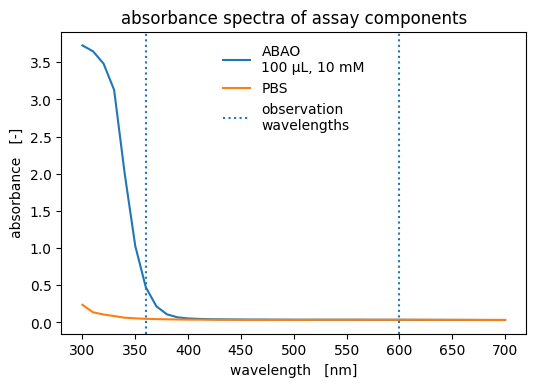

In [3]:
df_spec = pandas.read_excel(dataloading.fetch_file("SpektrumABAO_PBS.xlsx")).set_index("wavelength")

fig, ax = pyplot.subplots(dpi=100)

ax.plot(df_spec.index, df_spec.abao_absorbance, label="ABAO\n100 µL, 10 mM")
ax.plot(df_spec.index, df_spec.pbs_absorbance, label="PBS")
ax.axvline(360, ls=":", label="observation\nwavelengths")
ax.axvline(600, ls=":")
ax.set(
    title="absorbance spectra of assay components",
    ylabel="absorbance   [-]",
    xlabel="wavelength   [nm]",
)
ax.legend(frameon=False)

pyplot.show()

The absorbance of ABAO (the reaction educt) can not be neglected!

In [4]:
abao_shift = (df_spec.abao_absorbance - df_spec.pbs_absorbance)[360] / 2
display(df_spec.loc[[360, 600]])
print(f"The 360 nm absorbance of ABAO in the reaction accounts for {abao_shift} [a.u.].")

,abao_absorbance,pbs_absorbance
wavelength,,
360,0.473,0.049
600,0.036,0.036


The 360 nm absorbance of ABAO in the reaction accounts for 0.212 [a.u.].


# Calibration models of biomass CDW vs. absorbances
Also the biomass contributes to absorbance at 360 nm.

Using the calibration models fitted in this section, our process model can quantify the absolute biomass concentrations that explain observations made at 360 and 600 nm.

In [5]:
df_cal = dataloading.read_biomass_calibration().set_index("biomass")
df_cal

,A360,A600
biomass,,
11.635800,2.531,1.992
10.643600,2.434,1.939
9.741600,2.365,1.895
8.839600,2.327,1.876
8.118000,2.247,1.823
...,...,...
0.002848,0.053,0.038
0.002562,0.053,0.038
0.002364,0.052,0.036


Parameter scale_0 (0.0001) is close to its lower bound (0.0001).
Fit of LogisticBiomassAbsorbanceModel has failed:
      fun: -297.62746900391403
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.26578925e-01, -1.76680716e-01,  3.41316309e-01,  2.29442777e-01,
       -1.13118404e-01,  4.09818224e+03,  2.66493316e-01, -6.08224586e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1728
      nit: 169
     njev: 192
   status: 0
  success: True
        x: array([ 4.67401319e-02,  2.95998042e+00,  2.67763931e-01,  1.37580276e+00,
       -2.58652126e-01,  1.00000000e-04,  2.67480226e-02,  5.39763465e+00])


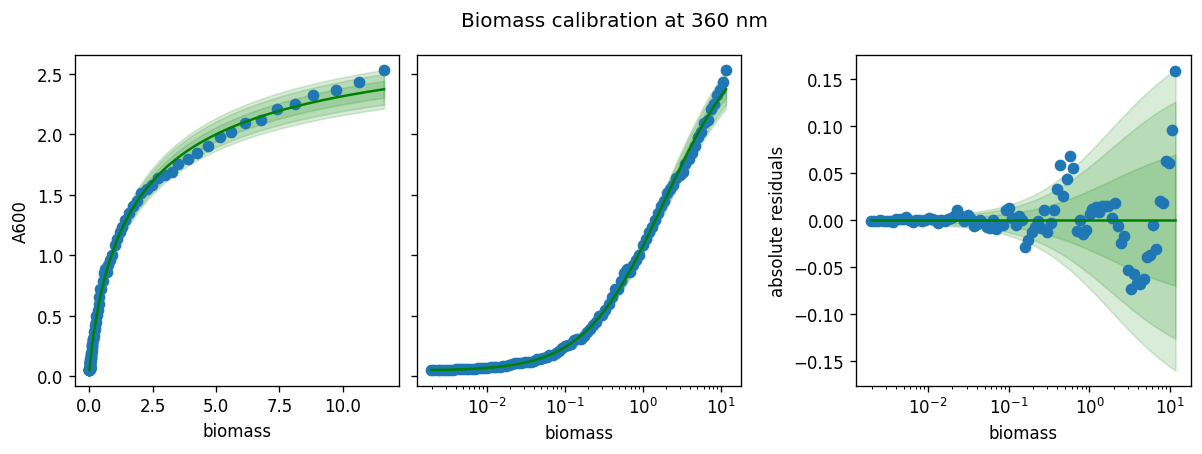

Parameter scale_0 (0.0001) is close to its lower bound (0.0001).
Fit of LogisticBiomassAbsorbanceModel has failed:
      fun: -344.6969343956695
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.26678071e-01, -3.17822925e-01, -1.27351996e-01,  7.49309952e-02,
        3.00877899e-01,  3.74999481e+03,  1.60798663e-01, -6.08599752e-01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1341
      nit: 119
     njev: 149
   status: 0
  success: True
        x: array([3.35713166e-02, 2.09133894e+00, 3.80337890e-01, 1.48852859e+00,
       5.79259469e-01, 1.00000000e-04, 2.43309051e-02, 4.12533861e+00])


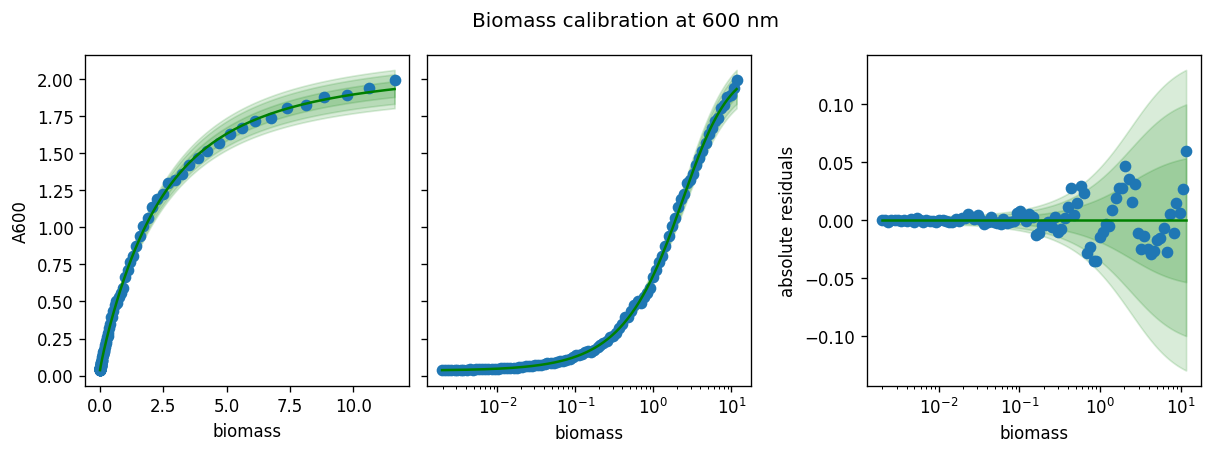

In [6]:
cms = {}
for wavelength in [360, 600]:
    cm = models.LogisticBiomassAbsorbanceModel()
    calibr8.fit_scipy(
        cm,
        independent=df_cal.index.to_numpy(),
        dependent=df_cal[f"A{wavelength}"].to_numpy(),
        theta_guess=[0, 5, 0, 2, -1] + [0.01, 0, 2],
        theta_bounds=[
            (-numpy.inf, 0.2), # L_L
            (1.5, numpy.inf),  # L_U
            (-3, 2),           # log10(I_x)
            (0.5, 3),          # Δy/Δlog10(x)
            (-3, 3),           # c
            (0.0001, 0.1),
            (0.0001, 0.1),
            (1, 30),
        ],
    )
    cm.save(f"cm_biomass_A{wavelength}.json")
    fig, ax = calibr8.plot_model(cm)
    fig.suptitle(f"Biomass calibration at {wavelength} nm")
    pyplot.show()
    cms[wavelength] = cm
    del cm

In [7]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Oct 12 2021

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.22.0

calibr8   : 6.1.0
numpy     : 1.21.0
ipywidgets: 7.6.3
pandas    : 1.3.0
matplotlib: 3.4.2

Watermark: 2.2.0

